<a href="https://colab.research.google.com/github/naguzmans/opportunistic-utm/blob/master/05_ConvLSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/opportunistic-utm/')

Mounted at /content/drive


# Check GPU

In [ ]:
!nvidia-smi

Sat Aug 13 15:25:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Define SARMSE Metric

In [ ]:
from numpy import dot
from numpy.linalg import norm

# Spatially Averaged Root Mean Square
def SARMSE(original, predicted):
  layer_rmse = np.sqrt(np.sum(np.square(original-predicted), axis=(0,1))/100**2)
  return np.sum(layer_rmse)/original.shape[-1] # divided by # of channels

def SAMAE(original, predicted):
  layer_mae = np.sum(np.abs(original-predicted), axis=(0,1))/100**2
  return np.sum(layer_mae)/original.shape[-1] # divided by # of channels

def SIMILARITY(original, predicted):
  voriginal = np.count_nonzero(original, axis=(0,1))
  vpredicted = np.count_nonzero(predicted, axis=(0,1))
  num = dot(voriginal, vpredicted)
  den = norm(voriginal)*norm(vpredicted)
  if den == 0:
    return 0
  else:
    return num/den

# Calculate Baselines

In [ ]:
# Metrics for Baselines
import numpy as np

def BSARMSE(original, predicted):
  layer_sarmse = 0
  for i in range(24): # Iterate hours
    for j in range(20): # Iterate flight levels
      layer_sarmse += np.sqrt(np.sum(np.square(original[...,j]-predicted[i,...,j])/(100*100)))
  return layer_sarmse/(20*24) # divided by # of channels and hours

def BSAMAE(original, predicted):
  layer_samae = 0
  for i in range(24): # Iterate hours
    for j in range(20): # Iterate flight levels
      layer_samae += np.sum(np.abs(original[...,j]-predicted[i,...,j]))/(100*100)
  return layer_samae/(20*24) # divided by # of channels and hours

def BSIMILARITY(original, predicted):
  layer_bsim = 0
  for i in range(24):
    for j in range(20):
      voriginal = np.count_nonzero(original[...,j])
      vpredicted = np.count_nonzero(predicted[i,...,j])
      num = dot(voriginal, vpredicted)
      den = norm(voriginal)*norm(vpredicted)
      if den == 0:
        layer_bsim += 0
      else:
        layer_bsim += num/den
  return layer_bsim/(20*24)

def BSAMAPE(original, predicted):
  layer_samape = 0
  for i in range(24): # Iterate hours
    for j in range(20): # Iterate flight levels
      operation = np.abs(original[...,j]-predicted[i,...,j])

      with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(operation, original[...,j])
        c[c == np.inf] = 0
        c = np.nan_to_num(c)
      
      layer_samape += np.sum(c)/(100*100)

  return (layer_samape/(20*24)) # divided by # of channels and hours

**Import year average**

In [ ]:
flights_average = np.load('dataset/00_results/flights_average_2018.npy')
flights_average.shape

(100, 100, 20)

In [ ]:
import glob
import numpy as np

# List of files with data
files_list = []
for file in glob.iglob(f'dataset/00_results/daily_unmasked/*.npy', recursive=False):
  files_list.append(file)

files_list = np.sort(files_list).tolist()[365:730]
files_list[0:10]
print(f'Files Length: {len(files_list)}')

Files Length: 365


**Average for the whole period**


In [ ]:
from tqdm import tqdm

sarmse_metric = 0
samae_metric = 0
sim_metric = 0

for file in tqdm(files_list):
  unmasked_day = np.load(file)
  sarmse_metric += BSARMSE(flights_average, unmasked_day)
  samae_metric += BSAMAE(flights_average, unmasked_day)
  sim_metric += BSIMILARITY(flights_average, unmasked_day)
  # print(sarmse_metric)

sarmse_metric /= len(files_list)
samae_metric /= len(files_list)
sim_metric /= len(files_list)

print(f'\n SARMSE: {sarmse_metric}')
print(f'SAMAE: {samae_metric}')
print(f'SIMILARITY: {sim_metric}')

100%|██████████| 365/365 [01:23<00:00,  4.37it/s]


 SARMSE: 0.08403183566026341
SAMAE: 0.010822561073059359
SIMILARITY: 0.47934360730593595


# ConvLSTM Model

**Dependencies**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, GRU, Dropout, TimeDistributed, MaxPooling3D

**Custom Keras Loss Function**

In [ ]:
from keras import backend as K

def custom_sarmse(y_true, y_pred):
  # print(f'True shape: {y_true.shape}')
  # print(f'Pred shape: {y_pred.shape}')
  a = K.square(y_true - y_pred + 1e-10)
  b = K.sum(a, [2,3], keepdims=True)
  c = K.sqrt(b)
  d = K.sum(c) /(100*20*4)
  return d

def custom_bce(y_true, y_pred):
 a = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits = True, axis = [2,3])
 b = K.mean(a)
#  c = K.sum(b)
 return b

def custom_mse(y_true, y_pred):
  a = K.square(y_true - y_pred + 1e-10)
  b = K.sum(a)
  # print(b)
  return b

**Model**

In [ ]:
inp = layers.Input(shape=(None, 100, 100, 20))
minp = layers.Input(shape=(None, 20))

def repeat_tabular(x_tab):
  h = x_tab[:, :, :, None, None]
  h = tf.tile(h, [1, 1, 5, 100, 1]) 
  return h
  
a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    # kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    # kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

y = tf.keras.layers.LSTM(64, return_sequences=True)(minp)
y = layers.Lambda(repeat_tabular)(minp)

x = tf.keras.layers.Concatenate()([a, b, c, y])
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.Dropout(0.1))(x)

x = layers.ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
    data_format='channels_last'
)(x)

model = keras.models.Model(inputs = [inp, minp], outputs = x)
model.compile(
    loss=custom_sarmse, optimizer=keras.optimizers.Adam(learning_rate = 0.0005), run_eagerly=False,
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 input_4 (InputLayer)           [(None, None, 20)]   0           []                               
                                                                                                  
 conv_lstm2d_4 (ConvLSTM2D)     (None, None, 100, 1  60032       ['input_3[0][0]']                
                                00, 32)                                                           
                                                                                            

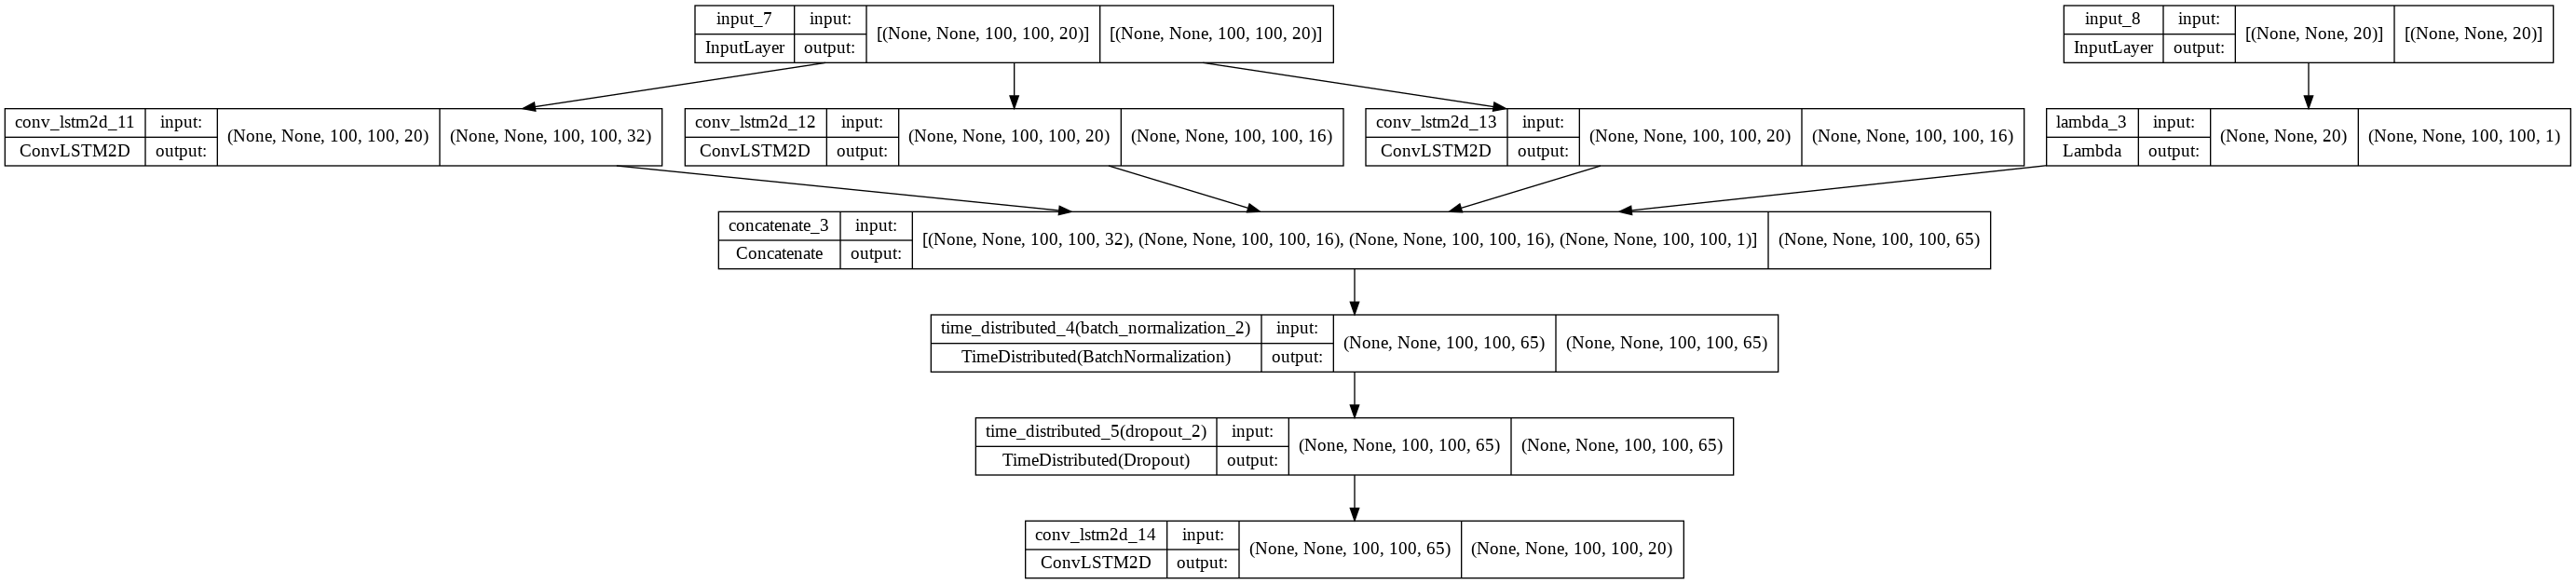

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Train model**

In [ ]:
import gc
gc.collect()

21345

In [ ]:
import glob

# List of folders with data
files_list = []
for filename in glob.iglob(f'dataset/00_results/daily_unmasked/*.npy', recursive=False):
  files_list.append(filename)

files_list = np.sort(files_list).tolist()
year_2018 = files_list[0:365]
year_2019 = files_list[365:730]
print(f'Number of Files: {len(files_list)}')

Number of Files: 730


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np   
tf.config.run_functions_eagerly(True)

def shift_array(data, metadata, shift=1):
  xdata = data[:, 0 : data.shape[1] - shift, :, :]
  xmetadata = metadata[:, 0 : metadata.shape[1] - shift, :]

  ydata = data[:, shift : data.shape[1], :, :]
  ymetadata = metadata[:, shift : metadata.shape[1], :]

  return [xdata, xmetadata], [ydata, ymetadata]

class DataGenerator(Sequence):
  def __init__(self, files_list, batch_size):
    self.files_list = files_list
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.files_list) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_list = self.files_list[idx * self.batch_size:(idx + 1) * self.batch_size]
    data_array = np.empty((1,24,100,100,20))
    metadata_array = np.empty((1,24,20))

    for file in batch_list:
      data_file = np.load(file)
      data_array = np.concatenate((data_array, np.expand_dims(data_file, axis=0)), axis=0)

      # metadata_file = np.load(file.replace('unmasked', 'metadata'))
      metadata_file = np.load(file.replace('unmasked', 'metadata'))[:,12:25]
      metadata_file = np.pad(metadata_file, [(0, 0), (0, 7)], mode='constant')
      metadata_array = np.concatenate((metadata_array, np.expand_dims(metadata_file, axis=0)), axis=0)

    return shift_array(data_array[1:], metadata_array[1:])

In [ ]:
train_gen = DataGenerator(year_2018[0:250], 4)
val_gen = DataGenerator(year_2018[250:365], 4)

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Fit the model to the training data.
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('', fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.axis('on')
plt.grid('on', alpha=.2)
plt.show()

# Metrics and Visualization

**Compare truth vs prediction**

In [ ]:
# Flattens multichannel array
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

In [ ]:
# Load average flights array
flights_average = np.load(f'dataset/00_results/flights_average_2018.npy')
flights_average.shape

(100, 100, 20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Cosine Similarity: 0.8706290442369842
SARMSE ConvLSTM Prediction: 0.030817713344164315
SARMSE Average Prediction: 0.08300544617674144


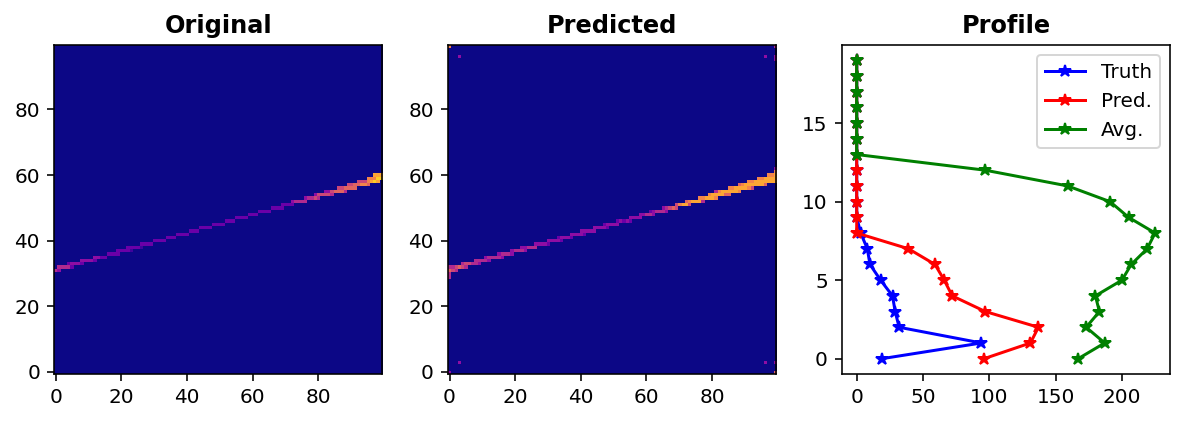

In [ ]:
from numpy import dot
from numpy.linalg import norm

# Select a random example from the validation dataset.
hour = 0
file = 'dataset/00_results/daily_unmasked/20190622.npy'
example = np.load(file)
mexample = np.load(file.replace('unmasked', 'metadata'))[:,12:25]
mexample = np.pad(mexample, [(0, 0), (0, 7)], mode='constant')

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
mframes = mexample[:10, ...]
original_frames = example[10:, ...]

new_prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(mframes, axis=0)])
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
predicted_frame = np.where(predicted_frame > 0, 1, 0)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(131)
ax1.imshow(flatten_array(original_frames[hour]), origin='lower', cmap = plt.get_cmap('plasma'), vmin=0, vmax=.5)
ax1.set_title('Original', fontweight='bold')

ax2 = fig.add_subplot(132)
ax2.imshow(flatten_array(predicted_frame[0]), origin='lower', cmap = plt.get_cmap('plasma'), vmin=0, vmax=.5)
ax2.set_title('Predicted', fontweight='bold')

original_level_count = []
for i in range(0, 20):
  original_level_count.append(np.count_nonzero(original_frames[hour][:,:,i]))

predicted_level_count = []
for i in range(0, 20):
  predicted_level_count.append(np.count_nonzero(predicted_frame[0][:,:,i]))

average_level_count = []
for i in range(0, 20):
  average_level_count.append(np.count_nonzero(flights_average[:,:,i]))

cos_sim = dot(original_level_count, predicted_level_count)/(norm(original_level_count)*norm(predicted_level_count))
print(f'Cosine Similarity: {cos_sim}')

ax3 = fig.add_subplot(133)
ax3.set_title('Profile', fontweight='bold')
ax3.plot(original_level_count, np.linspace(0, 19, 20), 'b*-')
ax3.plot(predicted_level_count, np.linspace(0, 19, 20), 'r*-')
ax3.plot(average_level_count, np.linspace(0, 19, 20), 'g*-')
ax3.legend(['Truth', 'Pred.', 'Avg.'])

asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)

# print(f'SARMSE Null Prediction: {SARMSE(original_frames[0], np.zeros((100,100,20)))}')
print(f'SARMSE ConvLSTM Prediction: {SARMSE(original_frames[hour], predicted_frame[0])}')
print(f'SARMSE Average Prediction: {SARMSE(original_frames[hour], flights_average)}')

In [ ]:
predicted_frame[0][...,1].shape

(100, 100)

In [ ]:
prediction_array = np.load('dataset/00_results/prediction_array.npy')
prediction_array.shape

(22, 100, 100, 20)

In [ ]:
prediction_array[0][:,:,0].shape

(100, 100)

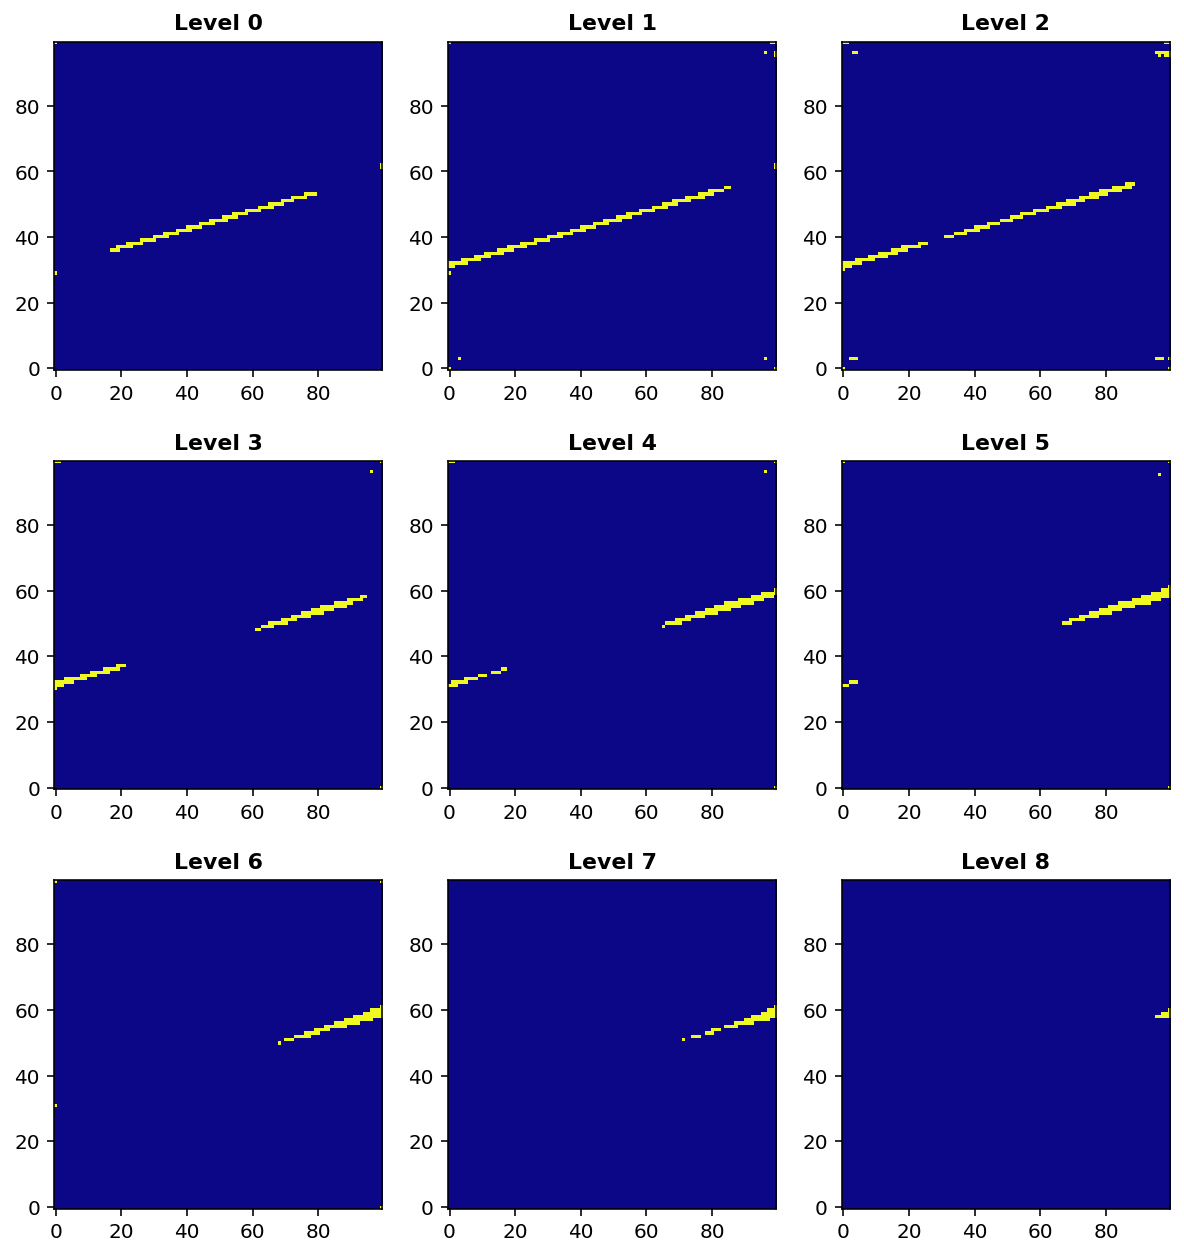

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=.95)

for i in range(0, 9):
  ax = fig.add_subplot(int(f'33{i+1}'))
  ax.imshow(prediction_array[11][:,:,i], origin='lower', cmap = plt.get_cmap('plasma'))
  ax.set_title(f'Level {i}', fontweight='bold', fontsize = '11')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


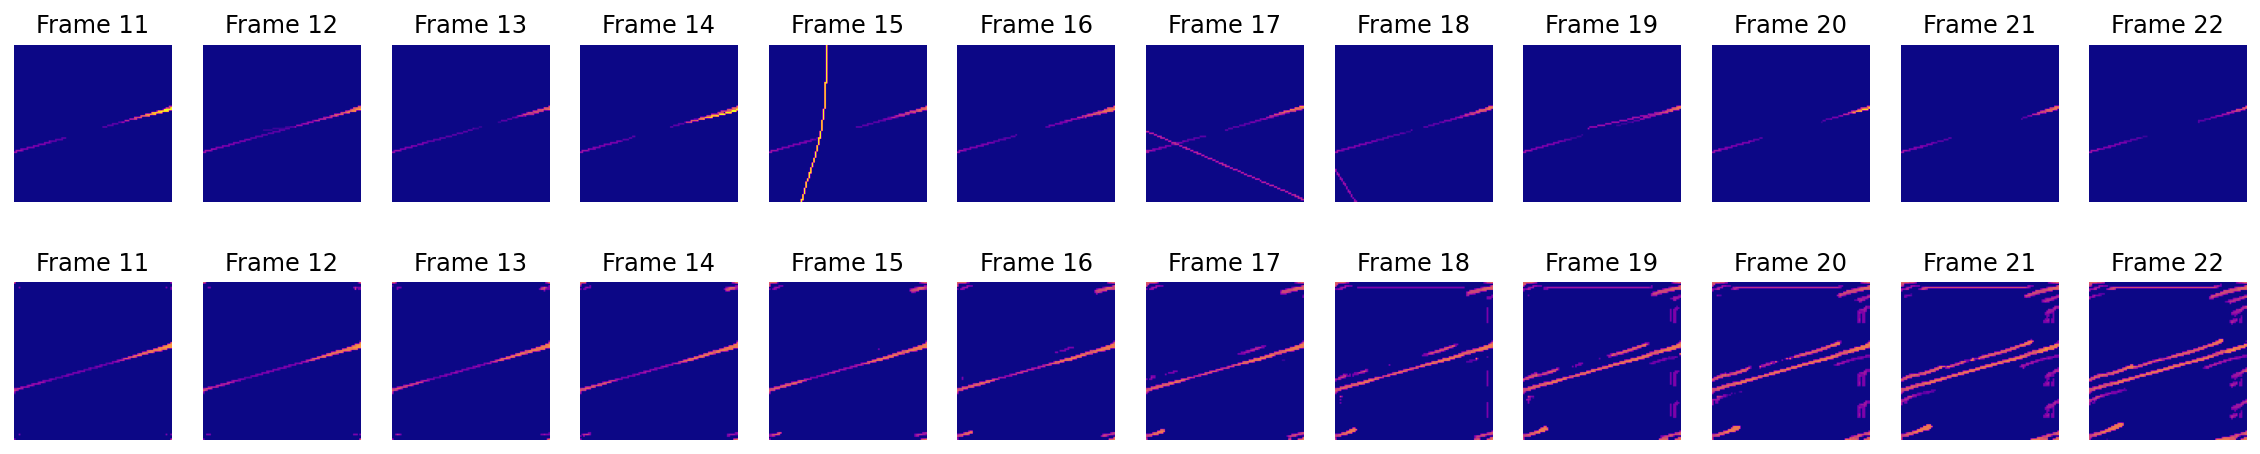


Final SARMSE: 
[0.0377497  0.03252745 0.03714002 0.0489221  0.04955455 0.04766484
 0.05470385 0.06084943 0.07190286 0.08309036 0.08663541 0.08863413]
Final SAMAE: 
[0.002525 0.002445 0.003445 0.00464  0.00568  0.005925 0.007865 0.00988
 0.013755 0.01702  0.019515 0.02066 ]
Final Similarity: 
[0.91597521 0.93483243 0.91782744 0.86295368 0.64508646 0.90473953
 0.8331393  0.86513308 0.89903459 0.88721176 0.96838251 0.81140374]


In [ ]:
import random

timespan = 12
# random_month = str(random.randint(1, 12)).zfill(2)
# random_day = str(random.randint(1, 28)).zfill(2)
file = f'dataset/00_results/daily_unmasked/20190921.npy'
example = np.load(file)
mexample = np.load(file.replace('unmasked', 'metadata'))[:,12:25]
mexample = np.pad(mexample, [(0, 0), (0, 7)], mode='constant')
frames = example[:10, ...]
original_frames = example[10:, ...]

sarmse_accum = np.zeros(timespan)
samae_accum = np.zeros(timespan)
similarity_accum = np.zeros(timespan)

for j in range(timespan):
  new_prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(mexample[:len(frames), ...], axis=0)])
  new_prediction = np.squeeze(new_prediction, axis=0)
  predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
  predicted_frame = np.where(predicted_frame > 0, 1, 0)

  # Add prediction to main frames
  frames = np.concatenate((frames, predicted_frame), axis=0)

  sarmse_value = SARMSE(original_frames[j], predicted_frame[0])
  sarmse_accum[j] += sarmse_value
  
  samae_value = SAMAE(original_frames[j], predicted_frame[0])
  samae_accum[j] += samae_value
  
  similarity_value = SIMILARITY(original_frames[j], predicted_frame[0])
  similarity_accum[j] += similarity_value

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, timespan, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(flatten_array(np.squeeze(original_frames[idx])), origin='lower', cmap='plasma', vmin=0, vmax=.6)
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(flatten_array(np.squeeze(new_frames[idx])), origin='lower', cmap='plasma', vmin=0, vmax=.6)
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")


# Display the figure.
plt.show()

print(f'\nFinal SARMSE: \n{sarmse_accum}')
print(f'Final SAMAE: \n{samae_accum}')
print(f'Final Similarity: \n{similarity_accum}')

In [ ]:
frames.shape
np.save('dataset/00_results/prediction_array.npy', frames)

In [ ]:
import random
from tqdm import tqdm

timespan = 12
sarmse_accum = np.zeros(timespan)
samae_accum = np.zeros(timespan)
similarity_accum = np.zeros(timespan)

accum = 0
total_days = 0
for month in tqdm(range(1,13)):
  for day in range(1,32):
    try:
      file = f'dataset/00_results/daily_unmasked/2019{str(month).zfill(2)}{str(day).zfill(2)}.npy'
      example = np.load(file)
      mexample = np.load(file.replace('unmasked', 'metadata'))[:,12:25]
      mexample = np.pad(mexample, [(0, 0), (0, 7)], mode='constant')
      frames = example[:10, ...]
      original_frames = example[10:, ...]

      total_days += 1

      for j in range(timespan):
        new_prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(mexample[:len(frames), ...], axis=0)])
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        predicted_frame = np.where(predicted_frame > 0, 1, 0)

        # Add prediction to main frames
        frames = np.concatenate((frames, predicted_frame), axis=0)

        # Calculate metrics
        sarmse_value = SARMSE(original_frames[j], predicted_frame[0])
        sarmse_accum[j] += sarmse_value

        samae_value = SAMAE(original_frames[j], predicted_frame[0])
        samae_accum[j] += samae_value

        similarity_value = SIMILARITY(original_frames[j], predicted_frame[0])
        similarity_accum[j] += similarity_value

        accum += 1
    except:
      print(f'{month}-{day}')
      pass

print(f'\nFinal SARMSE: \n{sarmse_accum/365}')
print(f'Final SAMAE: \n{samae_accum/365}')
print(f'Final Similarity: \n{similarity_accum/365}')

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
 17%|█▋        | 2/12 [04:07<20:25, 122.56s/it]

2-29
2-30
2-31


 33%|███▎      | 4/12 [08:27<16:58, 127.32s/it]

4-31


 50%|█████     | 6/12 [12:51<13:00, 130.09s/it]

6-31


 75%|███████▌  | 9/12 [19:29<06:35, 131.74s/it]

9-31


 92%|█████████▏| 11/12 [23:59<02:13, 133.18s/it]

11-31


100%|██████████| 12/12 [26:16<00:00, 131.42s/it]


Final SARMSE: 
[0.03990202 0.04468316 0.04770735 0.05136717 0.05433636 0.05752577
 0.05923391 0.06181511 0.06343801 0.06492252 0.06617776 0.06714457]
Final SAMAE: 
[0.00287992 0.00371553 0.00433719 0.00517166 0.00594389 0.00671762
 0.00742037 0.00808297 0.00871359 0.00932068 0.00985677 0.01026401]
Final Similarity: 
[0.86324211 0.84414056 0.83953565 0.81230594 0.78454537 0.76152512
 0.70452028 0.70728129 0.70023196 0.69047208 0.67163282 0.66888732]
